# Introduction

In this file, I explore the **K-Nearest Neighbors (KNN)** classification algorithm to predict whether an individual is a smoker based on demographic and health-related features from an insurance dataset. KNN is a **non-parametric**, **instance-based** learning method that classifies a new data point based on the majority class of its `k` nearest neighbors in the feature space.

I will:

- Preprocess and scale the dataset to ensure feature comparability.
- Implement KNN manually to deepen our understanding of the algorithm.
- Use scikit-learn's built-in `KNeighborsClassifier` for efficient training and evaluation.
- Evaluate model performance using **accuracy**, **confusion matrix**, **classification report**, and the **ROC curve**.

---

# Key Definitions

## K-Nearest Neighbors (KNN)

Given a query point $ x $, the KNN algorithm finds the $ k $ training examples closest to $ x $ using a distance metric (typically Euclidean distance). The predicted label is the **most frequent class** among these neighbors:

$$
\hat{y}(x) = \text{mode} \left( y_i \mid x_i \in \mathcal{N}_k(x) \right)
$$

- $ \mathcal{N}_k(x) $: The set of the $ k $ nearest neighbors of $ x $
- Distance is typically measured as:

$$
d(x_1, x_2) = \sqrt{ \sum_{i=1}^{n} (x_{1i} - x_{2i})^2 }
$$

- **No training phase**: KNN memorizes the dataset and classifies at inference time.
- **Sensitive to feature scale**: Hence, we standardize all features using `StandardScaler`.

**Goal**: Classify individuals as smokers or non-smokers using a simple, interpretable distance-based approach.


### Load and Encode Dataset

We import the insurance dataset and use **LabelEncoder** to convert categorical features (`sex`, `region`, `smoker`) into numeric format so that KNN can compute distances.


In [11]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

# --- Load and encode dataset ---
df = pd.read_csv("../Datasets/insurance.csv")
df_encoded = df.copy()
le = LabelEncoder()
df_encoded['sex'] = le.fit_transform(df_encoded['sex'])
df_encoded['region'] = le.fit_transform(df_encoded['region'])
df_encoded['smoker'] = le.fit_transform(df_encoded['smoker'])  # 1 = yes, 0 = no

###  Exploratory Visualizations

These plots help understand the distribution of smokers and how features like age, BMI, and charges relate to smoking status.


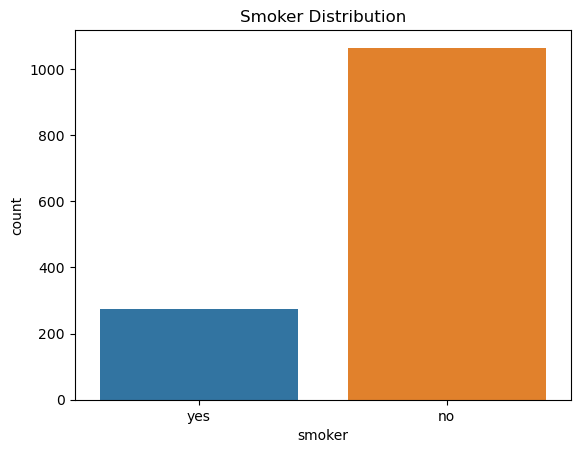

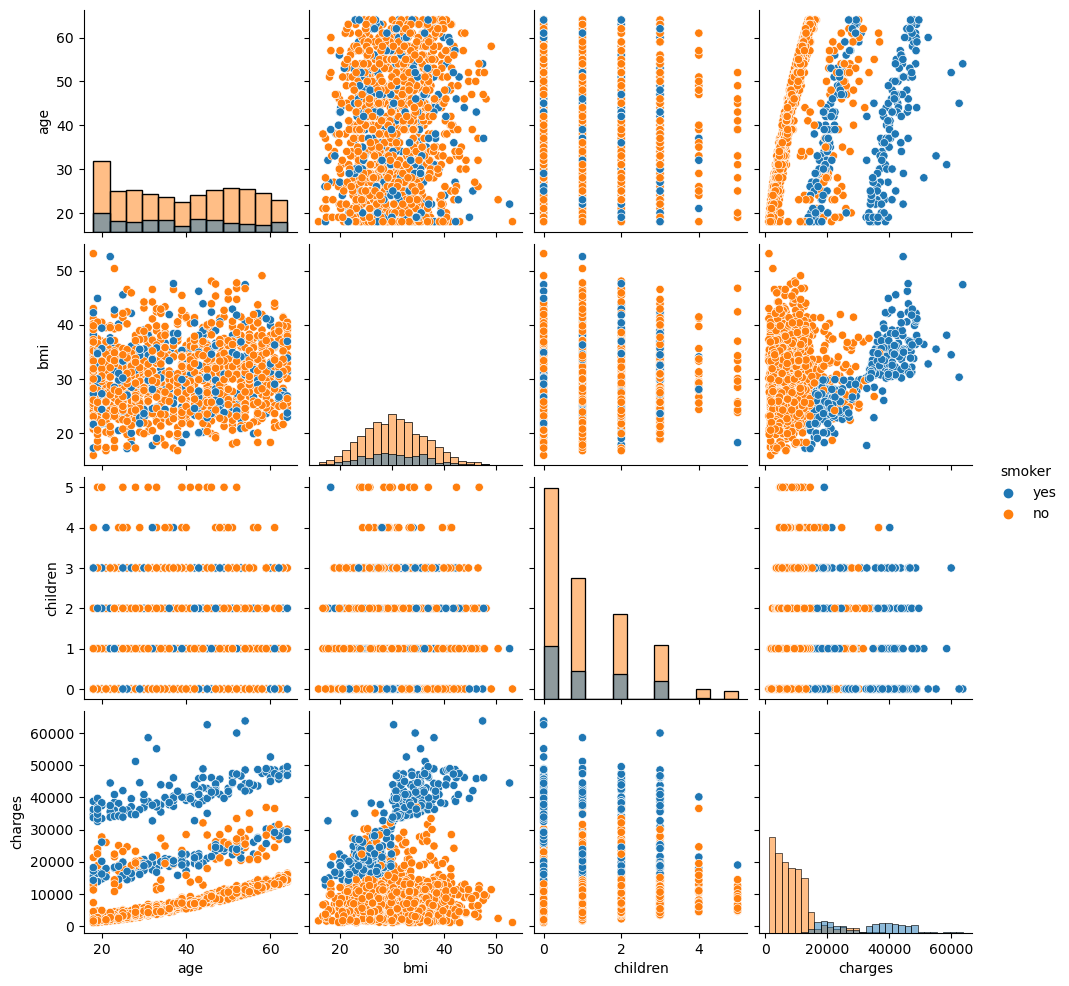

In [12]:

# --- Visualizations ---
sns.countplot(data=df, x='smoker')
plt.title("Smoker Distribution")
plt.show()

sns.pairplot(df, hue='smoker', diag_kind='hist')
plt.show()


This bar chart shows the count of smokers and non-smokers in the dataset.

- The classes are slightly imbalanced, with more non-smokers than smokers.
- Important to consider for evaluation metrics, as accuracy alone may be misleading in imbalanced datasets.

Class imbalance could impact model performance. Precision, recall, and AUC should also be evaluated.


The pairplot visualizes feature relationships (e.g., age, BMI, charges) colored by smoker status.

- Smokers tend to have higher charges.
- Slight differences in BMI and age distributions may also be visible.

Smoking has a strong effect on medical charges, which supports its predictive value in classification.


### Preprocessing and Data Splitting

We standardize all features using `StandardScaler` to ensure fair distance comparisons in KNN.

Then, we split the data into:
- **60% training**
- **20% validation**
- **20% test**

This structure allows us to:
- Tune hyperparameters on the validation set
- Evaluate final performance on unseen test data

In [13]:

# --- Feature selection and 60/20/20 split ---
X = df_encoded.drop("smoker", axis=1)
y = df_encoded["smoker"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

### Manual KNN Implementation

We define custom functions to compute Euclidean distance and make predictions:

This manual version helps us understand how KNN works internally:
- Compute distances to all training points
- Select `k` nearest neighbors
- Perform majority voting

In [14]:

# --- Manual KNN implementation ---
def euclidean_dist(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def knn_predict(X_train, y_train, X_test_point, k=5):
    distances = [euclidean_dist(X_test_point, x_train) for x_train in X_train]
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [y_train[i] for i in k_indices]
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

### Tune k Using Validation Accuracy

We loop through values of `k` from 1 to 20:

For each `k`, we:
- Predict on both the training and validation sets
- Calculate accuracy scores
- Store them for plotting and analysis

In [15]:
# --- Tune k using validation set ---
k_values = list(range(1, 21))
train_accuracies = []
val_accuracies = []

for k in k_values:
    # Train manual KNN on train set and evaluate on train and val
    y_train_pred = [knn_predict(X_train, y_train.tolist(), x, k) for x in X_train]
    y_val_pred = [knn_predict(X_train, y_train.tolist(), x, k) for x in X_val]

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

###  Plot Train vs Validation Accuracy

This graph helps visualize:
- Underfitting (low accuracy on both sets)
- Overfitting (high train, low validation)
- Optimal `k` (where validation accuracy peaks)

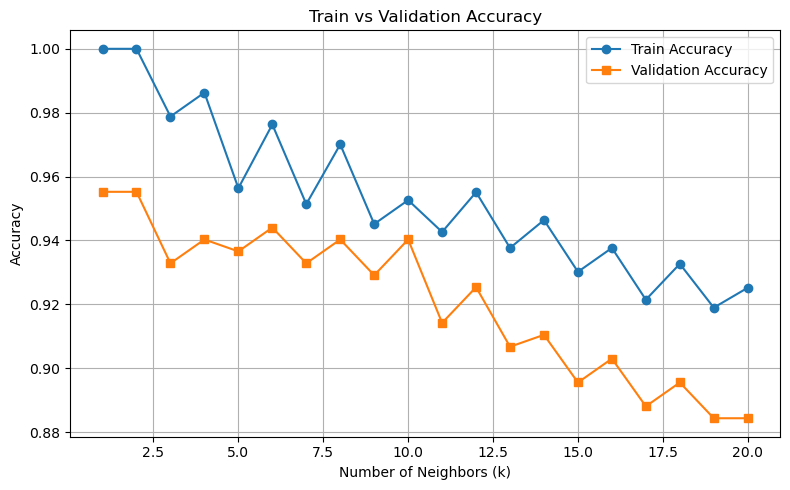

In [16]:
# --- Plot train vs validation accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(k_values, val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This line plot compares training and validation accuracy for different values of `k` (number of neighbors).

- Training accuracy decreases with increasing `k`, as the model becomes less flexible.
- Validation accuracy peaks around the best `k`, then declines due to underfitting.

Helps identify the optimal `k` that balances bias and variance.



### Final Model Training and Evaluation on Test Set

After identifying the best `k`, we merge the training and validation sets and retrain the model for final evaluation on the test set.

We evaluate the final model's accuracy and produce detailed classification metrics (precision, recall, F1-score) for each class (`smoker`, `non-smoker`).


In [17]:
# --- Choose best k and retrain on full train + val, then test ---
best_k = k_values[np.argmax(val_accuracies)]
print(f"Best k from validation: {best_k}")

X_full_train = np.vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

# --- Sklearn KNN with best k ---
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_full_train, y_full_train)
y_test_pred = knn.predict(X_test)

# --- Evaluation on test set ---
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with k={best_k}: {test_acc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=["non-smoker", "smoker"]))


Best k from validation: 1
Test Accuracy with k=1: 0.9552

Confusion Matrix:
 [[208   5]
 [  7  48]]

Classification Report:
               precision    recall  f1-score   support

  non-smoker       0.97      0.98      0.97       213
      smoker       0.91      0.87      0.89        55

    accuracy                           0.96       268
   macro avg       0.94      0.92      0.93       268
weighted avg       0.95      0.96      0.95       268





- **Best `k` selected**: `1` (based on validation accuracy)
- **Test Accuracy**: **95.52%**

- **208** true negatives (non-smokers correctly classified)
- **48** true positives (smokers correctly classified)
- **5** false positives (non-smokers misclassified as smokers)
- **7** false negatives (smokers misclassified as non-smokers)

The model performs very well with minimal misclassification on both classes.

- **Precision**: 91% for smokers — when the model predicts "smoker", it's correct 91% of the time.
- **Recall**: 87% for smokers — it correctly identifies 87% of actual smokers.
- **F1-score**: Balanced metric showing strong performance for both classes.

- The model achieves **high accuracy** with **balanced precision and recall**, especially for the minority class (smokers).
- Excellent performance with **very low error rates** and **robust generalization**.


###  ROC Curve

The ROC curve shows the trade-off between true positive and false positive rates across thresholds. The **AUC** (Area Under Curve) summarizes classifier performance—values closer to 1 indicate a strong model.


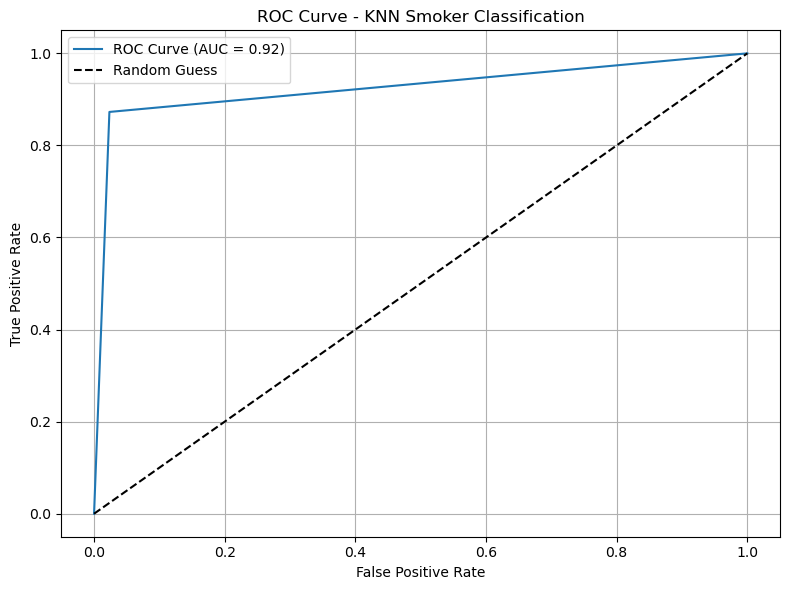

In [18]:

# --- ROC Curve ---
y_test_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN Smoker Classification")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



This plot visualizes the trade-off between the **true positive rate (sensitivity)** and the **false positive rate** at various classification thresholds.

- The **solid blue line** represents the performance of the KNN model.
- The **dashed diagonal line** indicates the performance of a random classifier (AUC = 0.5).
- The **Area Under the Curve (AUC)** is **0.92**, which is excellent.

- The model achieves a high true positive rate with a low false positive rate, especially at lower thresholds.
- An **AUC of 0.92** indicates the model is highly effective at distinguishing smokers from non-smokers across all thresholds.
- The curve’s steep rise near the top-left corner confirms **strong discriminatory power**.

The model is not only accurate but also **robust across classification thresholds**, making it reliable even in more sensitive applications.


## Conclusion and Future Work


In this project, I implemented a K-Nearest Neighbors (KNN) classifier to predict whether an individual is a smoker based on demographic and health-related features from an insurance dataset. 

The best-performing model used **k = 1**, achieving:
- **Test accuracy** of **95.52%**
- **Precision/Recall** of **0.91/0.87** for the smoker class
- **AUC of 0.92**, indicating excellent discriminatory power



### Weaknesses

- **Class imbalance**: The dataset contains significantly more non-smokers than smokers, which could bias the model’s performance despite high accuracy.
- **No feature engineering**: We used raw features without creating interaction terms or derived metrics, which may limit predictive power.
- **Manual KNN inefficiency**: The manual implementation is computationally slow and not scalable to larger datasets. Using an alrady build algorithm would be more scalable 
- **KNN sensitivity**: The model is sensitive to noisy data and irrelevant features since it relies purely on proximity in feature space.


### In the Future

-  **Feature Engineering**: Create new features like BMI categories or age groups to capture non-linear effects more explicitly.
- **Dimensionality Reduction**: Apply PCA or t-SNE to explore how separable the classes are and reduce overfitting.
- **Handle Imbalance**: Use SMOTE or class weighting to mitigate the imbalance between smokers and non-smokers.


KNN proved to be a simple yet highly effective baseline model for smoker classification in this dataset. With preprocessing and tuning, it achieved high accuracy and strong generalization. Still, further refinement and comparison to other models can help confirm and potentially improve upon these results.
